In [1]:
from transformers import ViTModel, ViTConfig
from transformers.models.vit.modeling_vit import ViTSelfAttention
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, random, json, math, time
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import ViTModel, ViTConfig
from torch.optim.lr_scheduler import CosineAnnealingLR

c:\Users\admin\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CFG:
    data_root = r"D:\CRWU Dataset\All_CWT"
    output_dir = "./PhysicsAwareViT_Output"
    model_name = "google/vit-base-patch16-224-in21k"
    seed = 42
    batch_size = 16
    num_workers = 4
    pin_memory = True
    lr = 3e-4
    weight_decay = 1e-4
    epochs = 20
    val_split = 0.2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = CFG()

In [3]:
# =====================================================
# TRANSFORMS
# =====================================================
tf_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

tf_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# =====================================================
# DATASET + STRATIFIED SPLIT
# =====================================================
base = ImageFolder(root=cfg.data_root)
random.seed(cfg.seed)

class_to_indices = {}
for idx, (_, y) in enumerate(base.samples):
    class_to_indices.setdefault(y, []).append(idx)

train_idx, val_idx = [], []
for y, idxs in class_to_indices.items():
    random.shuffle(idxs)
    n_val = max(1, int(round(len(idxs) * cfg.val_split)))
    val_idx += idxs[:n_val]
    train_idx += idxs[n_val:]
random.shuffle(train_idx); random.shuffle(val_idx)

full_train = ImageFolder(root=cfg.data_root, transform=tf_train)
full_val   = ImageFolder(root=cfg.data_root, transform=tf_val)
train_dataset = Subset(full_train, train_idx)
val_dataset   = Subset(full_val,   val_idx)

def collate_fn_preprocessed(batch):
    images, labels = zip(*batch)
    x = torch.stack([im for im in images]).float()
    if x.ndim == 4 and x.shape[1] == 1:
        x = x.repeat(1, 3, 1, 1)
    y = torch.tensor(labels, dtype=torch.long)
    return {"pixel_values": x, "labels": y}

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True,
                          collate_fn=collate_fn_preprocessed,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False,
                        collate_fn=collate_fn_preprocessed,
                        num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print("Classes:", base.classes)

Train samples: 640, Val samples: 160
Classes: ['BF', 'IR', 'N', 'OR']


In [5]:
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    collate_fn=collate_fn_preprocessed,
    num_workers=0,      # 🔧 single-threaded data loading
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    collate_fn=collate_fn_preprocessed,
    num_workers=0,
    pin_memory=False
)

In [6]:
from transformers.models.vit.modeling_vit import ViTSelfAttention

class BandAwareAttention(ViTSelfAttention):
    """
    Final, version-stable physics-aware attention layer.
    Adds learnable frequency-band bias, returns (context, attn_probs)
    to match Hugging Face ViTAttention expectations.
    """
    def __init__(self, config, num_bands=5):
        super().__init__(config)
        self.band_rel_bias = nn.Parameter(torch.zeros(num_bands, num_bands))
        nn.init.xavier_uniform_(self.band_rel_bias)
        self.band_dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, band_ids=None, **kwargs):
        bsz, seq_len, _ = hidden_states.shape

        query = self.query(hidden_states)
        key = self.key(hidden_states)
        value = self.value(hidden_states)

        query = self.transpose_for_scores(query)
        key = self.transpose_for_scores(key)
        value = self.transpose_for_scores(value)

        attn_scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.attention_head_size)

        # ✅ Add learnable frequency-band bias
        if band_ids is not None:
            if band_ids.dim() == 1:
                band_ids = band_ids.unsqueeze(0).repeat(bsz, 1)
            band_bias = self.band_rel_bias[band_ids][:, :, band_ids]
            band_bias = band_bias.unsqueeze(1)
            attn_scores = attn_scores + band_bias

        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.band_dropout(attn_probs)

        context = torch.matmul(attn_probs, value)
        context = context.permute(0, 2, 1, 3).contiguous()
        new_context = context.view(bsz, seq_len, self.all_head_size)

        # ✅ Return both context and attention probabilities
        return new_context, attn_probs






In [7]:
class PhysicsAwareViT(nn.Module):
    def __init__(self, cfg, num_classes, num_bands=5):
        super().__init__()
        vit_cfg = ViTConfig.from_pretrained(cfg.model_name)
        vit_cfg.num_labels = num_classes
        self.vit = ViTModel.from_pretrained(cfg.model_name, config=vit_cfg)
        self.hidden = vit_cfg.hidden_size
        self.num_bands = num_bands

        # Replace attention
        for blk in self.vit.encoder.layer:
            blk.attention.attention = BandAwareAttention(vit_cfg, num_bands=num_bands)

        self.band_embed = nn.Embedding(num_bands, self.hidden)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.hidden),
            nn.Linear(self.hidden, num_classes)
        )

    def forward(self, pixel_values, labels=None, band_ids=None):
        outputs = self.vit(pixel_values, output_hidden_states=True)
        cls_emb = outputs.last_hidden_state[:, 0]
        if band_ids is not None:
            band_emb = self.band_embed(band_ids)
            cls_emb = cls_emb + band_emb.mean(dim=1)
        logits = self.mlp_head(cls_emb)
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}



In [8]:
# =====================================================
# TRAINING UTILITIES
# =====================================================
def generate_band_ids(batch_size, num_patches=196, num_bands=5):
    ids = torch.arange(num_patches) % num_bands
    return ids.unsqueeze(0).repeat(batch_size, 1)

def accuracy_fn(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss, total_acc, steps = 0.0, 0.0, 0
    for batch in loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        band_ids = generate_band_ids(pixel_values.size(0)).to(device)
        out = model(pixel_values=pixel_values, labels=labels, band_ids=band_ids)
        total_loss += out["loss"].item()
        total_acc += accuracy_fn(out["logits"], labels)
        steps += 1
    return total_loss / steps, total_acc / steps



In [9]:
# =====================================================
# TRAINING LOOP
# =====================================================
model = PhysicsAwareViT(cfg, num_classes=len(base.classes)).to(cfg.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=cfg.epochs)
scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device.type == "cuda"))

os.makedirs(cfg.output_dir, exist_ok=True)
best_acc = 0.0
best_ckpt = os.path.join(cfg.output_dir, "best_model.pt")


C:\Users\admin\AppData\Local\Temp\ipykernel_23572\1595828569.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device.type == "cuda"))


In [10]:
for epoch in range(1, cfg.epochs + 1):
    model.train()
    epoch_loss, epoch_acc, steps = 0.0, 0.0, 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}", leave=False)
    for batch in pbar:
        pixel_values = batch["pixel_values"].to(cfg.device)
        labels = batch["labels"].to(cfg.device)
        band_ids = generate_band_ids(pixel_values.size(0)).to(cfg.device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(cfg.device.type == "cuda")):
            out = model(pixel_values=pixel_values, labels=labels, band_ids=band_ids)
            loss = out["loss"]

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        acc = accuracy_fn(out["logits"].detach(), labels)
        epoch_loss += loss.item(); epoch_acc += acc; steps += 1
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}")

    val_loss, val_acc = evaluate(model, val_loader, cfg.device)
    dt = time.time() - t0
    print(f"[{epoch:03d}] train_loss={epoch_loss/steps:.4f}, train_acc={epoch_acc/steps:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, time={dt:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_acc": val_acc,
            "cfg": vars(cfg)
        }, best_ckpt)
        print(f"  ✅ New best model saved with val_acc={val_acc:.4f}")

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

Epoch 1/20:   0%|          | 0/40 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_2356\4131002801.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.device.type == "cuda")):


[001] train_loss=1.0825, train_acc=0.4938, val_loss=0.8111, val_acc=0.5687, time=17.9s
  ✅ New best model saved with val_acc=0.5687


[002] train_loss=0.8471, train_acc=0.6031, val_loss=0.8608, val_acc=0.4625, time=20.6s


[003] train_loss=0.4942, train_acc=0.7797, val_loss=0.7329, val_acc=0.6000, time=20.7s
  ✅ New best model saved with val_acc=0.6000


[004] train_loss=0.4070, train_acc=0.8344, val_loss=0.2343, val_acc=0.8938, time=20.6s
  ✅ New best model saved with val_acc=0.8938


[005] train_loss=0.1829, train_acc=0.9375, val_loss=0.2196, val_acc=0.9000, time=20.9s
  ✅ New best model saved with val_acc=0.9000


[006] train_loss=0.2751, train_acc=0.9109, val_loss=0.2526, val_acc=0.8875, time=21.1s


[007] train_loss=0.1188, train_acc=0.9672, val_loss=0.2029, val_acc=0.9563, time=19.9s
  ✅ New best model saved with val_acc=0.9563


[008] train_loss=0.1422, train_acc=0.9531, val_loss=0.3048, val_acc=0.9000, time=19.9s


[009] train_loss=0.2588, train_acc=0.9266, val_loss=0.1922, val_acc=0.9437, time=20.0s


[010] train_loss=0.0749, train_acc=0.9781, val_loss=0.0749, val_acc=0.9812, time=19.9s
  ✅ New best model saved with val_acc=0.9812


[011] train_loss=0.0620, train_acc=0.9828, val_loss=0.1288, val_acc=0.9563, time=19.7s


[012] train_loss=0.0740, train_acc=0.9688, val_loss=0.0464, val_acc=0.9938, time=19.7s
  ✅ New best model saved with val_acc=0.9938


[013] train_loss=0.0442, train_acc=0.9844, val_loss=0.2535, val_acc=0.9313, time=19.7s


[014] train_loss=0.3204, train_acc=0.8969, val_loss=0.1639, val_acc=0.9625, time=19.7s


[015] train_loss=0.0566, train_acc=0.9859, val_loss=0.0933, val_acc=0.9750, time=19.7s


[016] train_loss=0.0458, train_acc=0.9906, val_loss=0.0369, val_acc=0.9938, time=19.8s


[017] train_loss=0.0513, train_acc=0.9766, val_loss=0.0697, val_acc=0.9812, time=19.8s


[018] train_loss=0.1336, train_acc=0.9516, val_loss=0.1130, val_acc=0.9563, time=19.7s


[019] train_loss=0.0835, train_acc=0.9734, val_loss=0.0483, val_acc=0.9875, time=19.7s


[020] train_loss=0.0458, train_acc=0.9906, val_loss=0.0530, val_acc=0.9812, time=19.7s
Training complete. Best validation accuracy: 0.9938


In [11]:
model = PhysicsAwareViT(cfg, num_classes=len(base.classes)).to(cfg.device)

In [19]:
print(model)

PhysicsAwareViT(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): BandAwareAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (band_dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768,

In [13]:
output_dir = r'E:\Farooq\NEUTech\PhysicsAwareViT_Output'
ckpt_path = os.path.join(cfg.output_dir, "best_model.pt")

# load checkpoint dictionary
checkpoint = torch.load(ckpt_path, map_location=cfg.device)

# extract model weights from it
model.load_state_dict(checkpoint["model_state"])

model.to(cfg.device)
model.eval()

print(f"✅ Model loaded successfully from {ckpt_path}")

✅ Model loaded successfully from ./PhysicsAwareViT_Output\best_model.pt


In [21]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs = batch["pixel_values"].to(cfg.device)
        labels = batch["labels"].to(cfg.device)

        # forward pass
        outputs = model(inputs)

        # if model returns dict, extract the logits
        if isinstance(outputs, dict):
            outputs = outputs["logits"]

        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Compute metrics ===
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=base.classes))

cm = confusion_matrix(all_labels, all_preds)
# print("Confusion Matrix:")
# print(cm)


✅ Validation Accuracy: 98.75%

Classification Report:
              precision    recall  f1-score   support

          BF       1.00      0.98      0.99        44
          IR       0.98      0.98      0.98        44
           N       1.00      1.00      1.00        28
          OR       0.98      1.00      0.99        44

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



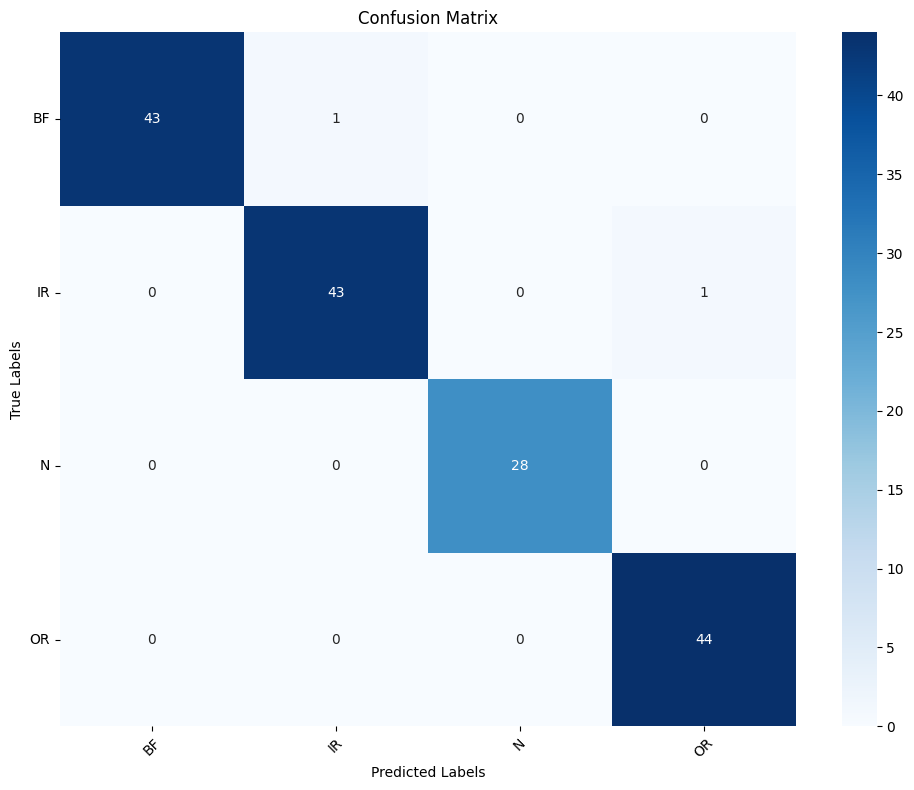

✅ Confusion matrix saved at: ./PhysicsAwareViT_Output\confusion_matrix.png


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Create and save confusion matrix plot ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=base.classes,
            yticklabels=base.classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save to file (high resolution)
save_path = os.path.join(cfg.output_dir, 'confusion_matrix.png')
plt.savefig(save_path, dpi=1000)
plt.show()
plt.close()

print(f"✅ Confusion matrix saved at: {save_path}")



Running t-SNE... this may take a while ⏳


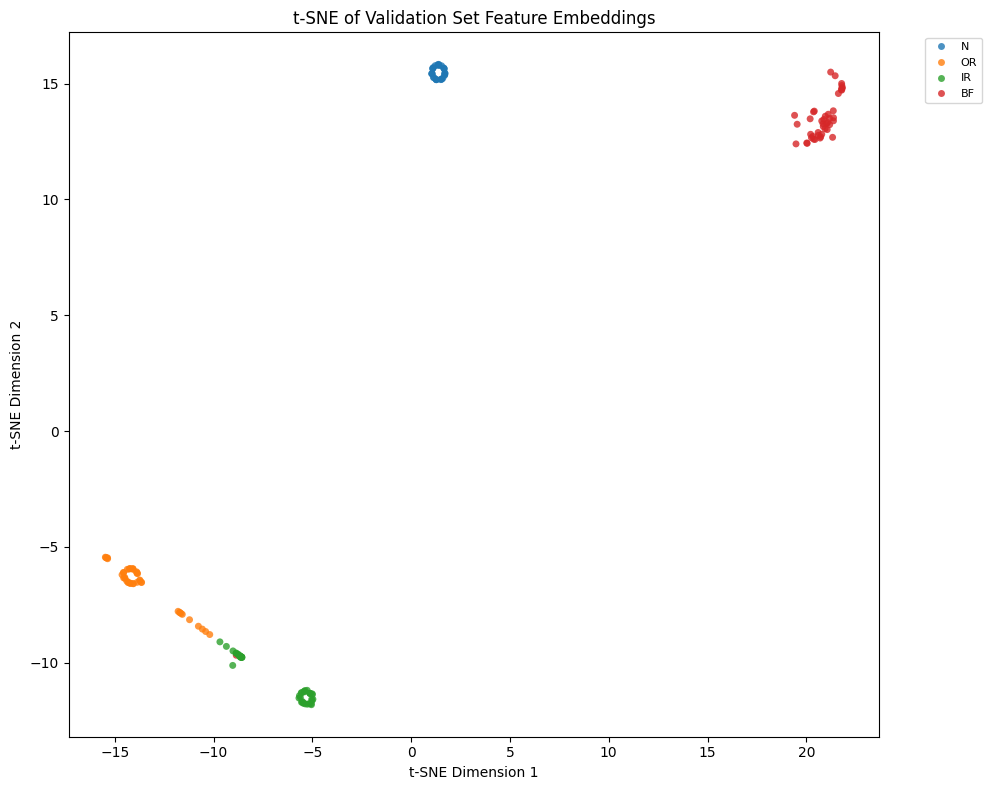

✅ t-SNE plot saved at: ./PhysicsAwareViT_Output\tsne_plot.png


In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Running t-SNE... this may take a while ⏳")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,         # ✅ fixed argument name
    random_state=42
)
X_2d = tsne.fit_transform(X)

# === Plot ===
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", len(base.classes))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1],
                hue=[base.classes[i] for i in y],
                palette=palette, s=25, alpha=0.8, edgecolor='none')

plt.title("t-SNE of Validation Set Feature Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()

# Save high-resolution image
save_path = os.path.join(cfg.output_dir, "tsne_plot.png")
plt.savefig(save_path, dpi=1000)
plt.show()
plt.close()
print(f"✅ t-SNE plot saved at: {save_path}")


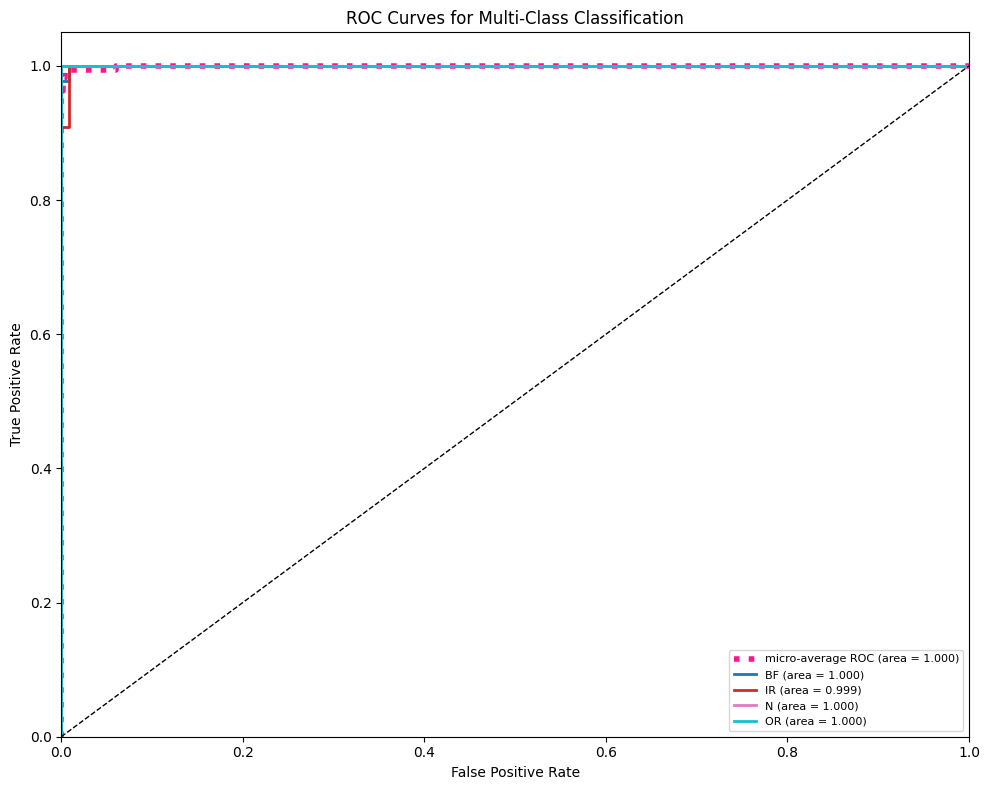

✅ ROC curves saved at: ./PhysicsAwareViT_Output\roc_curves.png


In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import os

model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs = batch["pixel_values"].to(cfg.device)
        labels = batch["labels"].to(cfg.device)

        outputs = model(inputs)
        if isinstance(outputs, dict):
            outputs = outputs["logits"]

        all_logits.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# === Convert to NumPy arrays ===
y_true = np.concatenate(all_labels)
y_score = np.concatenate(all_logits)

# === Binarize labels for ROC (One-vs-Rest) ===
y_true_bin = label_binarize(y_true, classes=list(range(len(base.classes))))

# === Compute ROC for each class ===
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(base.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# === Compute micro-average ROC ===
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# === Plot all ROC curves ===
plt.figure(figsize=(10, 8))

# Micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average ROC (area = {roc_auc['micro']:.3f})",
         color='deeppink', linestyle=':', linewidth=4)

# Each class ROC
colors = plt.cm.tab10(np.linspace(0, 1, len(base.classes)))
for i, color in zip(range(len(base.classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{base.classes[i]} (area = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()

# === Save high-res figure ===
roc_path = os.path.join(cfg.output_dir, "roc_curves.png")
plt.savefig(roc_path, dpi=1000)
plt.show()
plt.close()

print(f"✅ ROC curves saved at: {roc_path}")


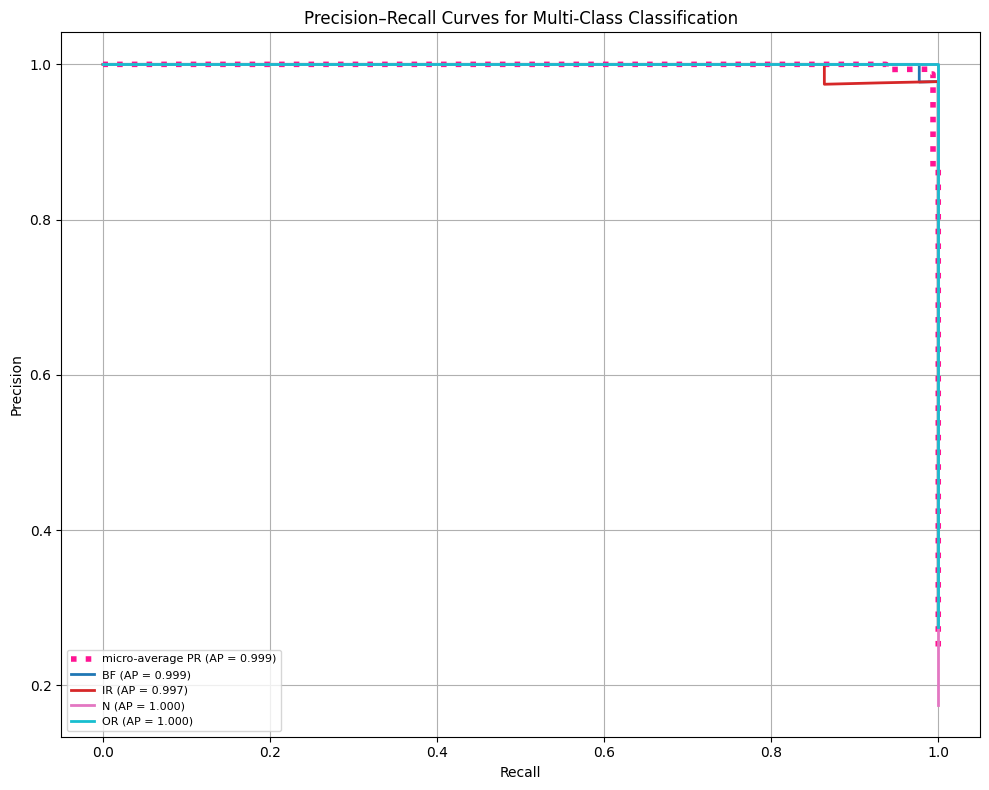

✅ Precision–Recall curves saved at: ./PhysicsAwareViT_Output\precision_recall_curves.png


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import os

model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs = batch["pixel_values"].to(cfg.device)
        labels = batch["labels"].to(cfg.device)

        outputs = model(inputs)
        if isinstance(outputs, dict):
            outputs = outputs["logits"]

        # Convert to probabilities
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_logits.append(probs)
        all_labels.append(labels.cpu().numpy())

# === Combine all predictions and labels ===
y_true = np.concatenate(all_labels)
y_score = np.concatenate(all_logits)

# === Binarize true labels for multi-class PR ===
y_true_bin = label_binarize(y_true, classes=list(range(len(base.classes))))

# === Compute Precision-Recall per class ===
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(base.classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

# === Compute micro-average Precision–Recall ===
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")

# === Plot all PR curves ===
plt.figure(figsize=(10, 8))

# Micro-average PR
plt.plot(recall["micro"], precision["micro"],
         label=f"micro-average PR (AP = {average_precision['micro']:.3f})",
         color='deeppink', linestyle=':', linewidth=4)

# Each class PR curve
colors = plt.cm.tab10(np.linspace(0, 1, len(base.classes)))
for i, color in zip(range(len(base.classes)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f"{base.classes[i]} (AP = {average_precision[i]:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for Multi-Class Classification")
plt.legend(loc="lower left", fontsize=8)
plt.grid(True)
plt.tight_layout()

# === Save figure ===
pr_path = os.path.join(cfg.output_dir, "precision_recall_curves.png")
plt.savefig(pr_path, dpi=600)
plt.show()
plt.close()

print(f"✅ Precision–Recall curves saved at: {pr_path}")
